Latest version (as of May 2021), includes density gradient, has options to vary resolution of velocity fields and add noise to velocities.

Last used (March 2022) to make data for day 5 (to compare test set to CNN)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import cmocean
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
zc=np.array([-481.68085,-446.76865,-414.0377,-383.35178,-354.58304,-327.6118,-302.32565,-278.61935,
                           -256.39423,-235.5577,-216.02301,-197.70883,-180.5389,-164.44174,-149.3503,-135.20177,
                           -121.937225,-109.50143,-97.84261,-86.91223,-76.664764,-67.05755,-58.050587,-49.60637,
                           -41.689735,-34.267727,-27.309437,-20.785896,-14.669938,-8.9361,-3.5605056,-0.5])

In [2]:
print(zc[31])

-0.5


## functions

In [2]:
def fourth_derivative(f,x,axis=0):
    """
    Takes the 4th derivative of an array using centered differencing, accuracy is O(dx)^2
    Only takes derivative in one direction
    
    INPUTS:
    f (2D arr): array of dependent variable (size nxm)
    x (1D arr): array of independent variable (size nx1 or mx1), assumes equal spacing
    axis (1 or 0): axis along which to take derivative in
    
    OUTPUTS:
    df (arr): array of size (n-4)x m or n x (m-4) of derivatives
    y (arr): array of corresponding derivative positions (y=x[2:-2])
    """
    
    df = np.ones((f.shape))*-9999.99
    dx = x[1]-x[0]
    
    for ind in range(len(x)-4):
        i = ind+2  # have to ignore first 2 points and last 2 points
        if axis==0:
            df[i,:] = (f[i+2,:]-4*f[i+1,:]+6*f[i,:]-4*f[i-1,:]+f[i-2,:])/(dx**4)
        else:
            df[:,i] = (f[:,i+2]-4*f[:,i+1]+6*f[:,i]-4*f[:,i-1]+f[:,i-2])/(dx**4)
    
    if axis==0: 
        df = df[2:-2,:]
    else:
        df = df[:,2:-2]
        
    y = x[2:-2]
    
    return df, y

def biharmonic_filter(f, y, kappa=0.062, axis=0):
    """
    computes f = f - kappa*f'''' to eliminate small scale noise
    
    INPUTS:
    f(arr): (nxm) arr of function values
    y(arr): (nx1) or (mx1) arr of position (assume equal spacing)
    kappa (float): mixing coefficient
    axis (int): axis to take 4th derivative along
    """
    
    df, y2 = fourth_derivative(f,y)
    
    if axis==0:
        signal_biharm = f[2:-2,:]-kappa*df 
    else:
        signal_biharm = f[:,2:-2]-kappa*df 
    
    return signal_biharm, y2

def read_psom_output(datadir,exp_name,t_ind):
    """
    Read PSOM outputs (full and face values) for the time indices indicated, and returns each variable
    concatenated of size (NK,NJ,NI,N_tsteps)
    
    INPUTS:

    """
    file_list = os.listdir(os.path.join(datadir,exp_name))
    file_list.sort()
    full_cdfs = [file for file in file_list if file.startswith('full_')]
    face_cdfs = [file for file in file_list if file.startswith('face_')] 
    
    print(full_cdfs[t_ind])
    nc_f = datadir + exp_name + full_cdfs[t_ind]
    DS = xr.open_dataset(nc_f)
    tr = np.array(DS.tr[:,1:-1,1:-1,1:-1])
    rho = np.array(DS.rho)[1:-1,1:-1,1:-1]  # ignore ghost points 
    vor = np.array(DS.vor)[1:-1,1:-1,1:-1]
    u = np.array(DS.u)[1:-1,1:-1,1:-1]
    v = np.array(DS.v)[1:-1,1:-1,1:-1]
    w = np.array(DS.w)[1:-1,1:-1,1:-1]
    DS.close()
    del DS
    
    print(face_cdfs[t_ind])
    nc_f = datadir + exp_name + face_cdfs[t_ind]
    DS = xr.open_dataset(nc_f)
    uf = DS.uf  # shape is (32,384,97)
    vf = DS.vf
    wf = np.array(DS.wf)*10**5 #convert to s^{-1}
    DS.close()
    del DS
        
    div = wf
        
    return [u,v,vor,rho,div,w]

def select_region(varlist, xrange=(0,-1),yrange=(0,151), k0=31):
    """
    Clip array to only include region of interest
    """
    X = varlist[0:-1]
    Y = varlist[-1]
    
    inputs = []
    for var in X: # loop over all input
        inputs.append(var[k0,yrange[0]:yrange[1],xrange[0]:xrange[1]])
    
    outputs = Y[:,yrange[0]:yrange[1],xrange[0]:xrange[1]]
    
    return (inputs, outputs)

def cross_shore_diff(var):
    """
    Calculate the difference of a variable from its location at y=L
    var(arr): 2D array with dimensions (NJ,NI)
    L(int): index for offshore location
    """
    L = np.shape(var)[0]
    var_offshore = np.repeat(var[-1,:][np.newaxis,:],L,axis=0)
    dvar = var-var_offshore
    return dvar

def cross_shore_gradient(var,dy):
    """
    Calculate the gradient of a variable in the cross-shore direction
    var(arr): 2D array with dimensions (NJ,NI)
    dy(float): grid spacing (in m)
    """
    dvar = (var[1:,:]-var[0:-1,:])/dy
    return dvar

def mld_N2peak(rho,threshold=0.03,li=2,ui=4,xs_extent=151):
    """
    Calculates MLD using a threshold from the -10m value and interpolating to get an exact depth.
    Also returns the max N2 (depth and value) within some range above and below the MLD
    INPUTS:
    -rho (NK,NJ,NI) arr
    -threshold (float): delta rho for calculating MLD from a depth of ~-10 m (surface depth is hard-coded)
    -li (int): number of grids below MLD to search for max N2
    -ui (int): number of grids above MLD to search for max N2
    OUTPUTS:
    -mld (NJxNI arr): mixed layer depth at every point
    -N2_max (NJxNI arr): max N2 value at every point
    -N2_max_z (NJxNI arr): depth of max N2 value (should be somewhat close to MLD)
    """
    N2 = -(9.8/(1025))*np.gradient(rho,zc,axis=0)*10**4 # 2nd order accurate central differencing in interior, first order at edges
    NI = rho.shape[-1]
    rho_0 = np.tile(rho[29,:,:],(32,1,1))
    mld = np.empty((xs_extent,98))
    N2_max = np.empty((xs_extent,98))
    N2_max_z = np.empty((xs_extent,98))

    for i in range(NI):
        for j in range(xs_extent):
            a = np.where(rho[:,j,i]-rho_0[:,j,i]>threshold)[0][-1] 
            b = a+1
            z_interp = np.arange(zc[a],zc[b],0.1)
            rho_interp = np.interp(z_interp, zc[a:b+1], rho[a:b+1,j,i])
            mld_ind = np.where(rho_interp>threshold)[0][-1]
            mld[j,i] = z_interp[mld_ind]

            N2_max[j,i] = np.max(N2[b-li:b+ui,j,i])
            N2_max_z[j,i]=zc[b-li+np.argmax(N2[b-li:b+ui,j,i])]

    return mld, N2_max, N2_max_z

def coarsen(feature, res):
    """
    INPUTS:
    -feature (arr) of size NJxNI
    -res (int): number of grid points to average together
    OUTPUTS:
    returns an array of size (NJ-NJ%res,NI-NI%res) which is a coarsed version of feature
    """
    NJ = feature.shape[0]
    NI = feature.shape[1]

    feature_coarse = np.empty((NJ,NI))

    for j in range(0,feature.shape[0],res):
        for i in range(0,feature.shape[1],res):
            feature_coarse[j:j+res,i:i+res] = np.median(feature[j:j+res,i:i+res])

    return feature_coarse[:NJ-(NJ%res),:NI-(NI%res)] # chop off end columns/rows that weren't used

def reshape_var(input_list, output_list):
    """
    reshapes variables at one snapshot in time
    
    INPUTS: 
    -input_list: list of variable arrays (list items are NJxNI arrays), e.g. X_filtered
    -output_list: list of output arrays (list elements are NJxNI arrays), e.g. Y_filtered
  
    OUTPUTS:
    -X (arr): size (num_pts, num_features/variables, 1)
    -Y (arr): size (num_pts, num_depths, 1)
    """
    first=True
    for w in output_list:
        if first:
            Y = np.reshape(w,(w.size,1,1))
            first=False
        else:
            y_temp = np.reshape(w,(w.size,1,1))
            Y = np.hstack((Y,y_temp))
            
    first = True
    for var in input_list:
        if first:
            X = np.reshape(var,(var.size,1,1))
            first = False
        else:
            x_temp = np.reshape(var,(var.size,1,1))
            X = np.hstack((X,x_temp))
            
    return X,Y

def divergence(u,v):
    """
    -Inputs: u & v (arr) size (NJ,NI)
    -Output: divergence (arr) size (NJ-2,NI-2)
    -assume dx, dy = 1km
    -uses centered differencing
    """
    dx = 1 # m, grid resolution
    dy = 1 # m, grid resolution
    
    dudx = (u[:,2:]-u[:,0:-2])/(2*dx)
    dvdy = (v[2:,:]-v[0:-2,:])/(2*dx)
    
    div = dudx[1:-1,:]+dvdy[:,1:-1]
    return div

def vorticity(u,v):
    """
    -Inputs: u & v (arr) size (NJ,NI)
    -Output: vorticity (arr) size (NJ-2,NI-2)
    -assume dx, dy = 1km
    -uses centered differencing
    """
    dx = 1 # m, grid resolution
    dy = 1 # m, grid resolution
    
    dvdx = (v[:,2:]-v[:,0:-2])/(2*dx)
    dudy = (u[2:,:]-u[0:-2,:])/(2*dy)
    
    vor = dvdx[1:-1,:]-dudy[:,1:-1]
    return vor


def A_theta_noise(U,V,noise_level):
    """
    Inputs: U,V (arr) size (NJ,NI)
    Outputs: unoise,vnoise (arr) size (NJ,NI)
    -applies white noise to A and theta, where u=Acos(theta) and v = Asin(theta)
    """
    A = (U**2+V**2)**(0.5)
    theta = np.arctan2(V,U)

    # create random noise (between 0 & 1)
    A_noise = np.random.rand(A.shape[0],A.shape[1])*noise_level*A
    theta_noise = (np.random.rand(theta.shape[0],theta.shape[1])-0.5)*noise_level*3.14159#np.mean(theta) 

    u2 = (A+A_noise)*np.cos(theta+theta_noise)
    v2 = (A+A_noise)*np.sin(theta+theta_noise)
    return u2,v2

## pre-processing pipeline

In [3]:
sims = ['g-W1d-1_NN1d-4/','g-W1d-1_NN1d-5/','g-W1d-1_NN5d-5/',
        'g-W1d-2_NN1d-4/','g-W1d-2_NN1d-5/','g-W1d-2_NN5d-5/',
        'g-W5d-2_NN1d-4/','g-W5d-2_NN1d-5/','g-W5d-2_NN5d-5/']

start_days = [35, 35, 28, 115, 87, 140, 68, 29, 51]
day = 5
Ls = [132, 48, 104, 57, 56, 91, 135, 53, 124]

noise_level=0
res = 5 # coarsened resolution in number of grid points

In [4]:
i = 0
# putting it all together (for one experiment)
datadir = '/Volumes/mahadevanlab/jing/PSOM_outputs/source depth paper/'
exp_name = sims[i]
start_day = start_days[i]+day

var_list = read_psom_output(datadir,exp_name,start_day)

L = 155

X,Y = select_region(var_list, xrange=(0,-1),yrange=(0,L), k0=31) # X is a list of feature arrays, Y is a 3D array of outputs

y = np.arange(L)
X_filtered=[]
Y_filtered=[]
for var in X:
    xf,yf = biharmonic_filter(var, y, kappa=0.062, axis=0)
    X_filtered.append(xf)  # X_filtered is a list of each feature array
    
for k in range(Y.shape[0]):
    wf,yf = biharmonic_filter(Y[k,:,:],y,kappa=0.062,axis=0)
    Y_filtered.append(wf)  # Y_filtered is a list of length 32 (length of depth)
    
## add any other variables (like MLD and N2) to X_filtered
rho = var_list[3] # want full 3D field
mld, N2_max, N2_max_z = mld_N2peak(rho,threshold=0.03,li=2,ui=4,xs_extent=L)
X_filtered.extend([mld,N2_max])

## calculate drho from rho
grad_rho = np.gradient(X_filtered[3]) #cross_shore_gradient(X_filtered[3],1) # units of density/km
grad_mag = (grad_rho[0]**2 + grad_rho[1]**2)**0.5
X_filtered.extend([grad_rho[0],grad_rho[1],grad_mag])
X_filtered[3] = cross_shore_diff(X_filtered[3])

## coarsen any variables, X_filtered=[u,v,vor,rho,div]
inds = [0,1,2,4] # features in X_filtered to coarsen
for ind in inds:
    feature = X_filtered[ind]
    feature_coarsened = coarsen(feature,res)
    X_filtered[ind]=feature_coarsened
    NJ_new = feature_coarsened.shape[0]-1 # subtract one for grad_rho
    NI_new = feature_coarsened.shape[1]
# make all features the same size as coarsened ones
for x in range(len(X_filtered)):
    X_filtered[x] = X_filtered[x][:NJ_new,:NI_new]
for y in range(len(Y_filtered)):
    Y_filtered[y] = Y_filtered[y][:NJ_new,:NI_new]

## noisy velocities, replace u & v with noisy velocities and re-calculate divergence
U = X_filtered[0]
V = X_filtered[1]
div = divergence(U,V)
vor_psom = X_filtered[2]
vor = vorticity(U,V)
u2,v2 = A_theta_noise(U,V,noise_level)
div2 = divergence(u2,v2)
vor2 = vorticity(u2,v2)

X_filtered[0]=u2
X_filtered[1]=v2
X_filtered[4]=div2
X_filtered[2]=vor2

# make all features the same size as divergence array
NJ_new = div2.shape[0]
NI_new = div2.shape[1]
    
for x in range(len(X_filtered)):
    X_filtered[x] = X_filtered[x][:NJ_new,:NI_new]
for y in range(len(Y_filtered)):
    Y_filtered[y] = Y_filtered[y][:NJ_new,:NI_new]

X_temp,Y_temp = reshape_var(X_filtered, Y_filtered) # X and Y are for a single day for one experiment

#with open('training_samples_mld_N2_%ikm/'%res+exp_name[:-1]+'_day%i.pkl' %start_day,'wb') as f:
#    pickle.dump((X_temp,Y_temp),f)

full_32000.cdf
face_32000.cdf


## plot data at a snapshot

In [5]:
print(X_filtered[1].shape)
print(X_temp.shape)
print(rho.shape)
print(grad_rho[1].shape)
print(len(X_filtered))

(147, 93)
(13671, 10, 1)
(32, 384, 96)
(151, 95)
10


In [6]:
#with open('training_samples_mld_N2_drho_%ikm/'%res+exp_name[:-1]+'_day%i.pkl' %start_day,'wb') as f:
#    pickle.dump((X_temp,Y_temp),f)

print(X_filtered[8].shape)
print(Y_filtered[0].shape)


(147, 93)
(147, 93)


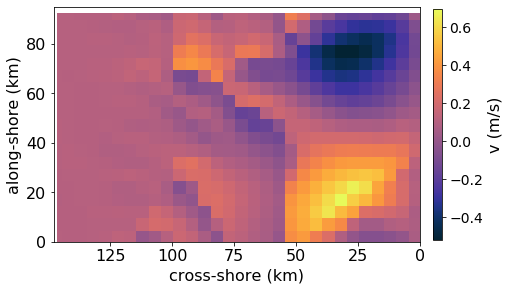

In [7]:
# plot inputs
ind = 1

f = 0.376*10**(-4)

feat = ['u','v','vor','drho','div','mld','N2peak','drho_dy','drho_dx','grad_rho_mag']
labels=['u (m/s)','v (m/s)',r'$\zeta/f$',r'$\Delta\rho$ (kg/m$^3$)',r'$\nabla_H \cdot \vec{u}$  (s$^{-1}$)','MLD (m)',
        r'$N^2_{peak}$ ($\times 10^{-4}~$s$^{-2}$)',
        r'$\frac{\partial \rho}{\partial y}$(kg/m$^3$/km)',r'$\frac{\partial \rho}{\partial x}$(kg/m$^3$/km)',r'$|\nabla \rho|$ (kg/m$^3$/km)']

text_font={'family': 'sans-serif', 'fontsize': 16, 'fontweight': 'normal'}
savefigdir='/Users/jing/Desktop/' #Dropbox (MIT)/Research_ch2/figures/calypso/rf inputs/'

plt.figure(figsize=(8,5))
if ind==2:
    midnorm = MidpointNormalize(vmin=-2, vcenter=0, vmax=6) 
    plt.imshow(X_filtered[ind].T/f,cmap=cmocean.cm.balance, norm=midnorm)
else:
    #midnorm = MidpointNormalize(vmin=-.15, vcenter=0, vmax=0.1) # for divergence
    plt.imshow(X_filtered[ind].T,cmap=cmocean.cm.thermal)
    
plt.xlim([148,0])
plt.ylim([0,95])
plt.xlabel('cross-shore (km)',fontdict=text_font)
plt.ylabel('along-shore (km)',fontdict=text_font)
plt.tick_params(axis='both', which='major', labelsize=16)

c=plt.colorbar(aspect=25, pad=0.03,shrink=0.85)
c.set_label(labels[ind],fontdict=text_font)
c.ax.tick_params(labelsize=14)
#plt.savefig(savefigdir+exp_name[:-1]+'day%i'%start_day+feat[ind]+'.pdf',bbox_inches='tight',dpi=300)

-34.267727


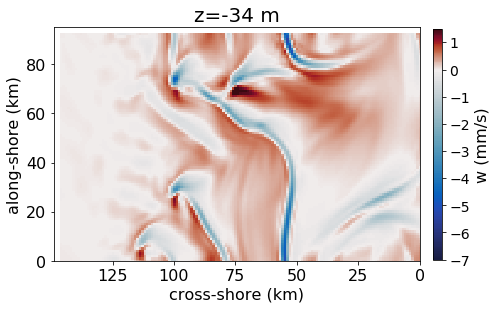

In [8]:
# plot outputs
ind = 25
c = 1 #to convert from mm/s to m/day
print(zc[ind])

text_font={'family': 'sans-serif', 'fontsize': 16, 'fontweight': 'normal'}
savefigdir='/Users/jing/Dropbox (MIT)/Research_ch2/figures/calypso/rf inputs/'

plt.figure(figsize=(8,5))
midnorm = MidpointNormalize(vmin=-7*c, vcenter=0*c, vmax=1.5*c) 
plt.imshow(Y_filtered[ind].T*c,cmap=cmocean.cm.balance,norm=midnorm)
    
plt.xlim([149,0])
plt.ylim([0,95])
plt.xlabel('cross-shore (km)',fontdict=text_font)
plt.ylabel('along-shore (km)',fontdict=text_font)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('z=%i m'%zc[ind],fontsize=20)

c=plt.colorbar(aspect=25, pad=0.03,shrink=0.85)
c.set_label('w (mm/s)',fontdict=text_font)
c.ax.tick_params(labelsize=14)
#plt.savefig(savefigdir+exp_name[:-1]+'day%i'%start_day+'w_z%im.pdf'%zc[ind],bbox_inches='tight',dpi=300)

## preproc data for multiple experiments and multiple days

In [9]:
# multiple experiments and multiple days

datadir = '/Volumes/mahadevanlab/jing/PSOM_outputs/source depth paper/'
L = 155 # first try fixed width L (then try variable L)

for i in range(len(sims)):
    exp_name = sims[i]
    start_day = start_days[i]+day
    
    var_list = read_psom_output(datadir,exp_name,start_day)
    
    X,Y = select_region(var_list, xrange=(0,-1),yrange=(0,L), k0=31) # X is a list of feature arrays, Y is a 3D array of outputs

    y = np.arange(L)
    X_filtered=[]
    Y_filtered=[]
    for var in X:
        xf,yf = biharmonic_filter(var, y, kappa=0.062, axis=0)
        X_filtered.append(xf)  # X_filtered is a list of each feature array

    for k in range(Y.shape[0]):
        wf,yf = biharmonic_filter(Y[k,:,:],y,kappa=0.062,axis=0)
        Y_filtered.append(wf)  # Y_filtered is a list of length 32 (length of depth)

    ## add any other variables (like MLD and N2) to X_filtered
    rho = var_list[3] # want full 3D field
    mld, N2_max, N2_max_z = mld_N2peak(rho,threshold=0.03,li=2,ui=4,xs_extent=L)
    X_filtered.extend([mld,N2_max])
    
    ## calculate drho from rho
    grad_rho = np.gradient(X_filtered[3]) #cross_shore_gradient(X_filtered[3],1) # units of density/km
    grad_mag = (grad_rho[0]**2 + grad_rho[1]**2)**0.5
    X_filtered.extend([grad_rho[0],grad_rho[1],grad_mag])
    X_filtered[3] = cross_shore_diff(X_filtered[3])

    ## coarsen any variables
    inds = [0,1,2,4] # features in X_filtered to coarsen
    for ind in inds:
        feature = X_filtered[ind]
        feature_coarsened = coarsen(feature,res)
        X_filtered[ind]=feature_coarsened
        NJ_new = feature_coarsened.shape[0]-1
        NI_new = feature_coarsened.shape[1]
    
    # make all features the same size as coarsened ones
    for x in range(len(X_filtered)):
        X_filtered[x] = X_filtered[x][:NJ_new,:NI_new]
    for y in range(len(Y_filtered)):
        Y_filtered[y] = Y_filtered[y][:NJ_new,:NI_new]
    
## noisy velocities, replace u & v with noisy velocities and re-calculate divergence
    # if not adding noise, comment out this entire section
    #--------------------------------------------------------------------
    if noise_level>0:
        U = X_filtered[0]
        V = X_filtered[1]
        div = divergence(U,V)
        u2,v2 = A_theta_noise(U,V,noise_level)
        div2 = divergence(u2,v2)
        vor2 = vorticity(u2,v2)

        X_filtered[0]=u2
        X_filtered[1]=v2
        X_filtered[2]=vor2
        X_filtered[4]=div2

        NJ_new = div2.shape[0]
        NI_new = div2.shape[1]

        for x in range(len(X_filtered)):
            X_filtered[x] = X_filtered[x][:NJ_new,:NI_new]
        for y in range(len(Y_filtered)):
            Y_filtered[y] = Y_filtered[y][:NJ_new,:NI_new]

    #--------------------------------------------------------------------

    X_temp,Y_temp = reshape_var(X_filtered, Y_filtered) # X and Y are for a single day for one experiment
    #print(X_filtered.shape)
    #print(Y_filtered.shape)
    if i==0:
        inputs = X_temp
        outputs = Y_temp
    else:
        inputs = np.vstack((inputs,X_temp))
        outputs = np.vstack((outputs,Y_temp))

full_32000.cdf
face_32000.cdf
full_32000.cdf
face_32000.cdf
full_26400.cdf
face_26400.cdf
full_48000.cdf
face_48000.cdf
full_36800.cdf
face_36800.cdf
full_58000.cdf
face_58000.cdf
full_29200.cdf
face_29200.cdf
full_13600.cdf
face_13600.cdf
full_22400.cdf
face_22400.cdf


In [10]:
with open('training_samples_mld_N2_drho_%ikm/%inoise_day%i.pkl'%(res,noise_level*100, day),'wb') as f:
    pickle.dump((inputs,outputs),f)

In [ ]:
print(noise_level*100)
print(res)

In [ ]:
print(inputs.shape)

In [ ]:
print(res)

In [ ]:
print(inputs.shape)
print(outputs.shape)

In [ ]:
#with open('rf_training_samples_filtered/g-W1d-1_NN1d-4_day40.pkl','rb') as f:
#    xd5, yd5 = pickle.load(f)
